In [1]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import cellrank as cr
import scipy
import scipy.io
import numpy as np
import anndata as ad
import os.path
scv.set_figure_params()
scv.settings.set_figure_params('scvelo')

subset_id = "AM_early_EB"

work_dir = "/ceph/rimlsfnwi/data/moldevbio/veenstra/snabel/scrna/CMdiff_mon-EB-EHT_combined/rerun_v4/subsets/20220201_Py_scvelo/"
dataset_path = "/ceph/rimlsfnwi/data/moldevbio/veenstra/snabel/scrna/CMdiff_mon-EB-EHT_combined/rerun_v4/subsets/20220201_ProtocolEarlyLateSubsets_ClustUMAP_toPy/subsets/"

In [2]:
dataset_path = dataset_path+subset_id+"/"
resultdir = work_dir+subset_id+"_output"
os.makedirs(resultdir)
os.chdir(resultdir)

#### Data locations & Other parameters

In [3]:
## Data locations ##
raw_spliced_path = dataset_path + "seurat_sf_counts.mtx"
raw_unspliced_path = dataset_path + "seurat_uf_counts.mtx"

features_path = dataset_path + "seurat_sf_genes.tsv"
barcodes_path = dataset_path + "seurat_sf_barcodes.tsv"
metadata_path = dataset_path + "seurat_metadata.csv"
umap_path = dataset_path + "seurat_umap_embedding.csv"
HVG_path = dataset_path + "seurat_integrated_genes.tsv"

## Parameters to set ##
pc_set = 20
cluster_ident = "coarse_seurat_clusters"

#### Loading data

In [4]:
raw_spliced = scipy.io.mmread(raw_spliced_path)
raw_unspliced = scipy.io.mmread(raw_unspliced_path)
metadata = pd.read_csv(metadata_path, index_col = 0)
umap_embedding = np.asmatrix(pd.read_csv(umap_path, index_col = 0))

In [5]:
## Edits to make adata.var matrix
barcodedata = pd.read_csv(barcodes_path, sep = "\t", header = None)[0].to_list()
featuredata = pd.read_csv(features_path, sep = "\t", header = None)[0].to_list()
featuredata = pd.DataFrame(featuredata, index = featuredata)
featuredata.columns = ['gene']
HVG = pd.read_csv(HVG_path, sep = "\t", header = None)[0].to_list()

In [6]:
metadata.index = barcodedata
raw_spliced.index = barcodedata
raw_unspliced.index = barcodedata

In [7]:
## Building the adata object, matrices from Seurat need Transposing before adding.
adata = ad.AnnData(X = raw_spliced.todense().T,
                   obs = metadata,
                   var = featuredata
                  )
adata.layers["spliced"] = raw_spliced.todense().T
adata.layers["unspliced"] = raw_unspliced.todense().T
adata.obsm["X_umap"] = umap_embedding

In [8]:
len(metadata.index)

2054

In [9]:
adata.layers["spliced"][1:10,1:10]

matrix([[2, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 6, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 5, 0, 0, 0, 0],
        [1, 0, 0, 0, 2, 0, 0, 0, 0]])

In [10]:
adata.layers
#adata.var['vst.variable']

Layers with keys: spliced, unspliced

In [11]:
adata.X[1:10,1:10]

array([[2., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 6., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [1., 0., 0., 0., 2., 0., 0., 0., 0.]], dtype=float32)

In [12]:
adata.obs.head()

orig.ident  nCount_sf  nFeature_sf  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8      GRCh38       6224         2866   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15     GRCh38       4915         2385   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1      GRCh38       3694         2046   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14     GRCh38       4406         2296   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9      GRCh38       3633         2055   

                                          Genome Spikein  Reporter Method  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8   GRCh38    ERCC  reporter     EB   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15  GRCh38    ERCC  reporter     EB   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1   GRCh38    ERCC  reporter     EB   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14  GRCh38    ERCC  reporter     EB   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9   GRCh38    ERCC  reporter     EB   

                                         Lineage Timepoint  Replicate  ...  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8       AM       d10          1  ...   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15      AM       d10          1  ...   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1       AM       d10          1  ...   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14      AM       d10          1  ...   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9       AM       d10          1  ...   

                                          integrated_snn_res.1.5  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8                        7   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15                       2   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1                        1   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14                       2   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9                        3   

                                         seurat_clusters   S.Score  G2M.Score  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8                7  0.015484  -0.060277   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15               2 -0.014700  -0.150623   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1                1 -0.238162  -0.140127   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14               2 -0.126297  -0.131346   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9                3 -0.111098  -0.224336   

                                          Phase  integrated_snn_res.0.9  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8       S                      17   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15     G1                      14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1      G1                       7   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14     G1                      14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9      G1                       7   

                                          coarse_seurat_clusters  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8                       17   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15                      14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1                        7   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14                      14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9                        7   

                                          seurat_clusters_atlas1.5  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8                         18   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15                        15   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1                          9   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14                        15   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9                          9   

                                          coarse_seurat_clusters_atlas  \
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P8                             17   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_L15                            14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_D1                              7   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_P14                            14   
GRCh38_ERCC_reporter_EB_AM_d10_1_942_E9                              7   

            

In [13]:
adata.obs = adata.obs.astype(str)

... storing 'orig.ident' as categorical
... storing 'nCount_sf' as categorical
... storing 'nFeature_sf' as categorical
... storing 'Genome' as categorical
... storing 'Spikein' as categorical
... storing 'Reporter' as categorical
... storing 'Method' as categorical
... storing 'Lineage' as categorical
... storing 'Timepoint' as categorical
... storing 'Replicate' as categorical
... storing 'Library' as categorical
... storing 'Well' as categorical
... storing 'combined_id' as categorical
... storing 'nCounts' as categorical
... storing 'nGene' as categorical
... storing 'sum' as categorical
... storing 'detected' as categorical
... storing 'altexps_ERCC_sum' as categorical
... storing 'altexps_ERCC_detected' as categorical
... storing 'altexps_ERCC_percent' as categorical
... storing 'altexps_MT_sum' as categorical
... storing 'altexps_MT_detected' as categorical
... storing 'altexps_MT_percent' as categorical
... storing 'total' as categorical
... storing 'use' as categorical
... sto

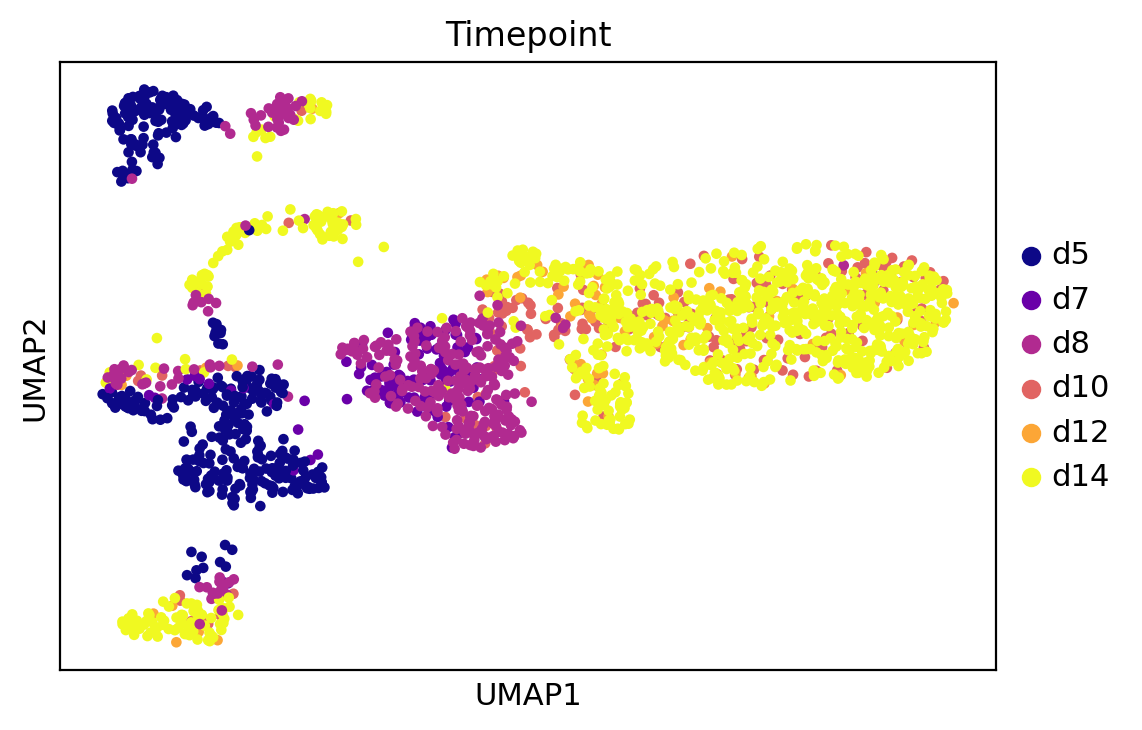

In [14]:
sc.pl.umap(adata, color = "Timepoint", palette = "plasma")

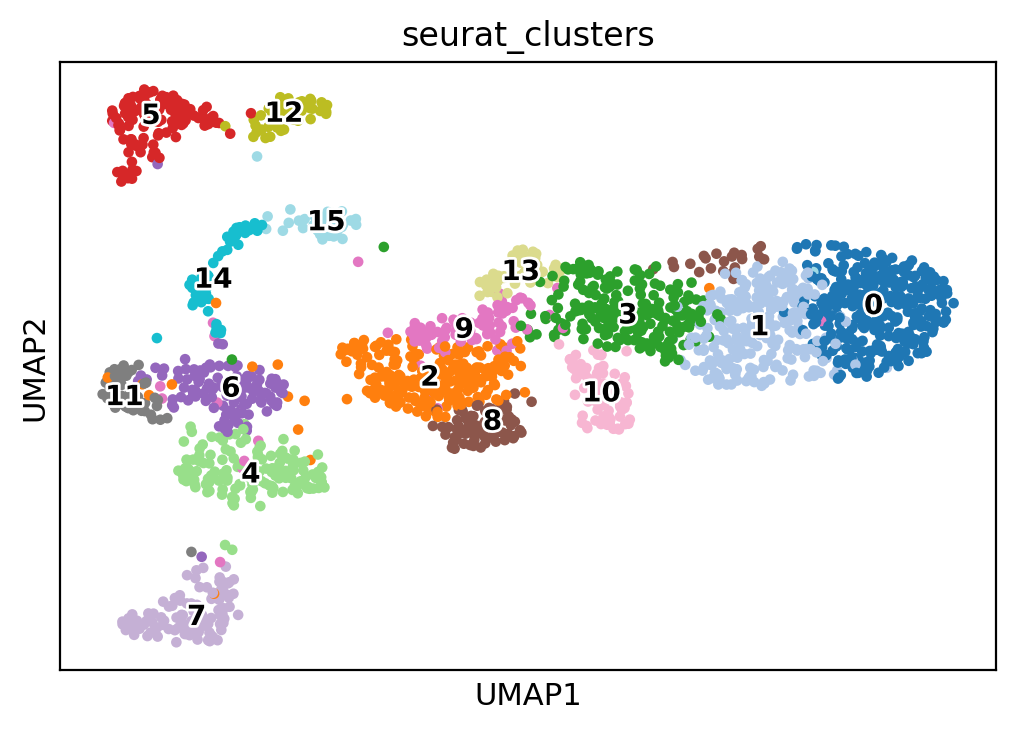

In [15]:
sc.pl.umap(adata, color = "seurat_clusters", palette = "tab20", legend_loc='on data', legend_fontsize=10, legend_fontoutline=2,)

In [16]:
### Running needed steps to determine Velocity
np.shape(adata.X)

(2054, 20799)

In [17]:
#scv.pl.proportions(adata, groupby="seurat_clusters")

In [18]:
adata.obsm['X_umap']

matrix([[ -8.04563459, -12.54431122],
        [ -0.92439398,  -1.43883794],
        [  5.85951034,  -0.80917424],
        ...,
        [ -4.08898335,  -0.04697519],
        [ -0.14120587,   0.44212604],
        [  0.02376167,  -2.35817736]])

In [19]:
scv.pp.filter_and_normalize(adata, min_shared_counts=None, n_top_genes=None)
#scv.pp.normalize_per_cell(adata, layers = ["X", "spliced", "unspliced"])
adata.raw = adata


Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [20]:
adata = adata[:,adata.var.index.isin(HVG)]

In [21]:
adata

View of AnnData object with n_obs × n_vars = 2054 × 2000
    obs: 'orig.ident', 'nCount_sf', 'nFeature_sf', 'Genome', 'Spikein', 'Reporter', 'Method', 'Lineage', 'Timepoint', 'Replicate', 'Library', 'Well', 'combined_id', 'nCounts', 'nGene', 'sum', 'detected', 'altexps_ERCC_sum', 'altexps_ERCC_detected', 'altexps_ERCC_percent', 'altexps_MT_sum', 'altexps_MT_detected', 'altexps_MT_percent', 'total', 'use', 'nCount_uf', 'nFeature_uf', 'Experiment', 'integrated_snn_res.1.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.9', 'coarse_seurat_clusters', 'seurat_clusters_atlas1.5', 'coarse_seurat_clusters_atlas', 'Protocol_AM_early_EB', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene', 'gene_count_corr'
    uns: 'Timepoint_colors', 'seurat_clusters_colors'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [22]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [23]:
scv.tl.recover_dynamics(adata, n_jobs = 10)
scv.tl.velocity(adata, mode = 'dynamical')

recovering dynamics (using 10/64 cores)


  0%|          | 0/1097 [00:00<?, ?gene/s]

/vol/mbconda/snabel/anaconda3/envs/py_scvelo/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/vol/mbconda/snabel/anaconda3/envs/py_scvelo/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [25]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [38]:
adata.write(subset_id + 'seuset_velocity.h5ad', compression='gzip')
#adata = scv.read('seuset_velocity.h5ad')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_VelocityPlot_embedding_Arrows_Timepoint.pdf


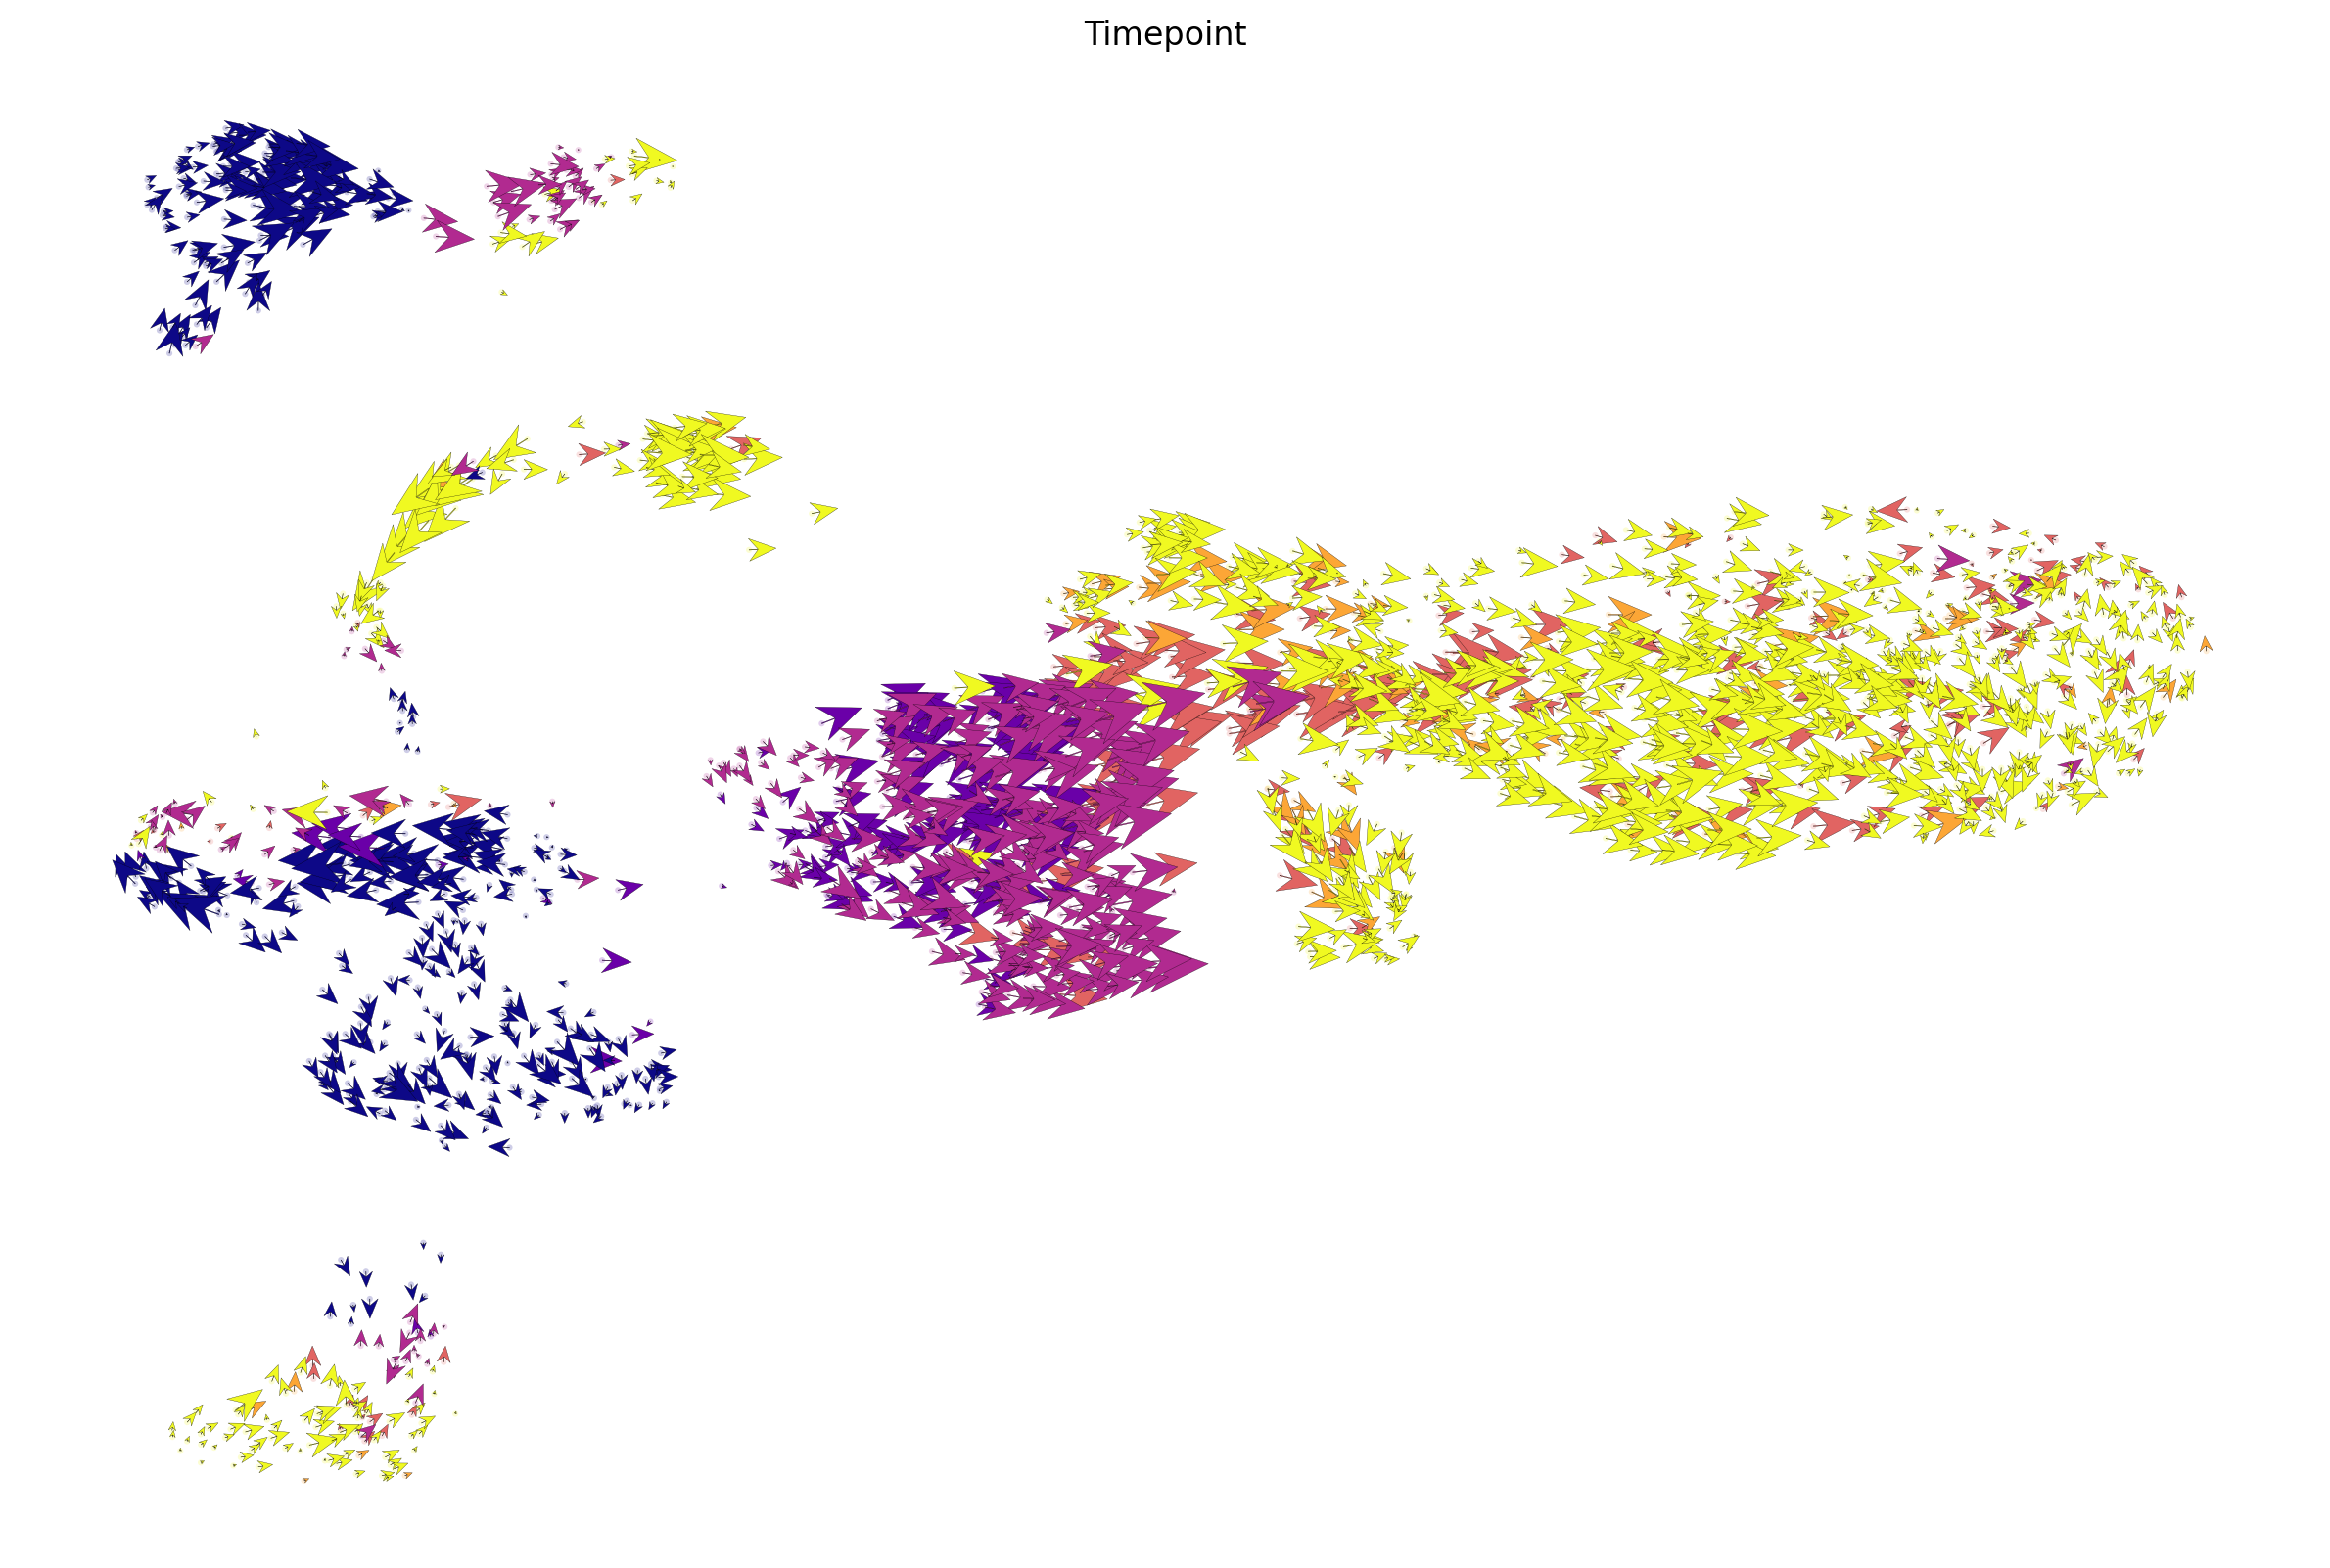

In [26]:
scv.pl.velocity_embedding(adata, basis = "umap", 
                          color = "Timepoint", 
                          arrow_length= 5, figsize=(15,10), arrow_size= 5,
                         save="VelocityPlot_embedding_Arrows_Timepoint.pdf")

saving figure to file ./figures/scvelo_VelocityPlot_GridArrows_Timepoint.pdf


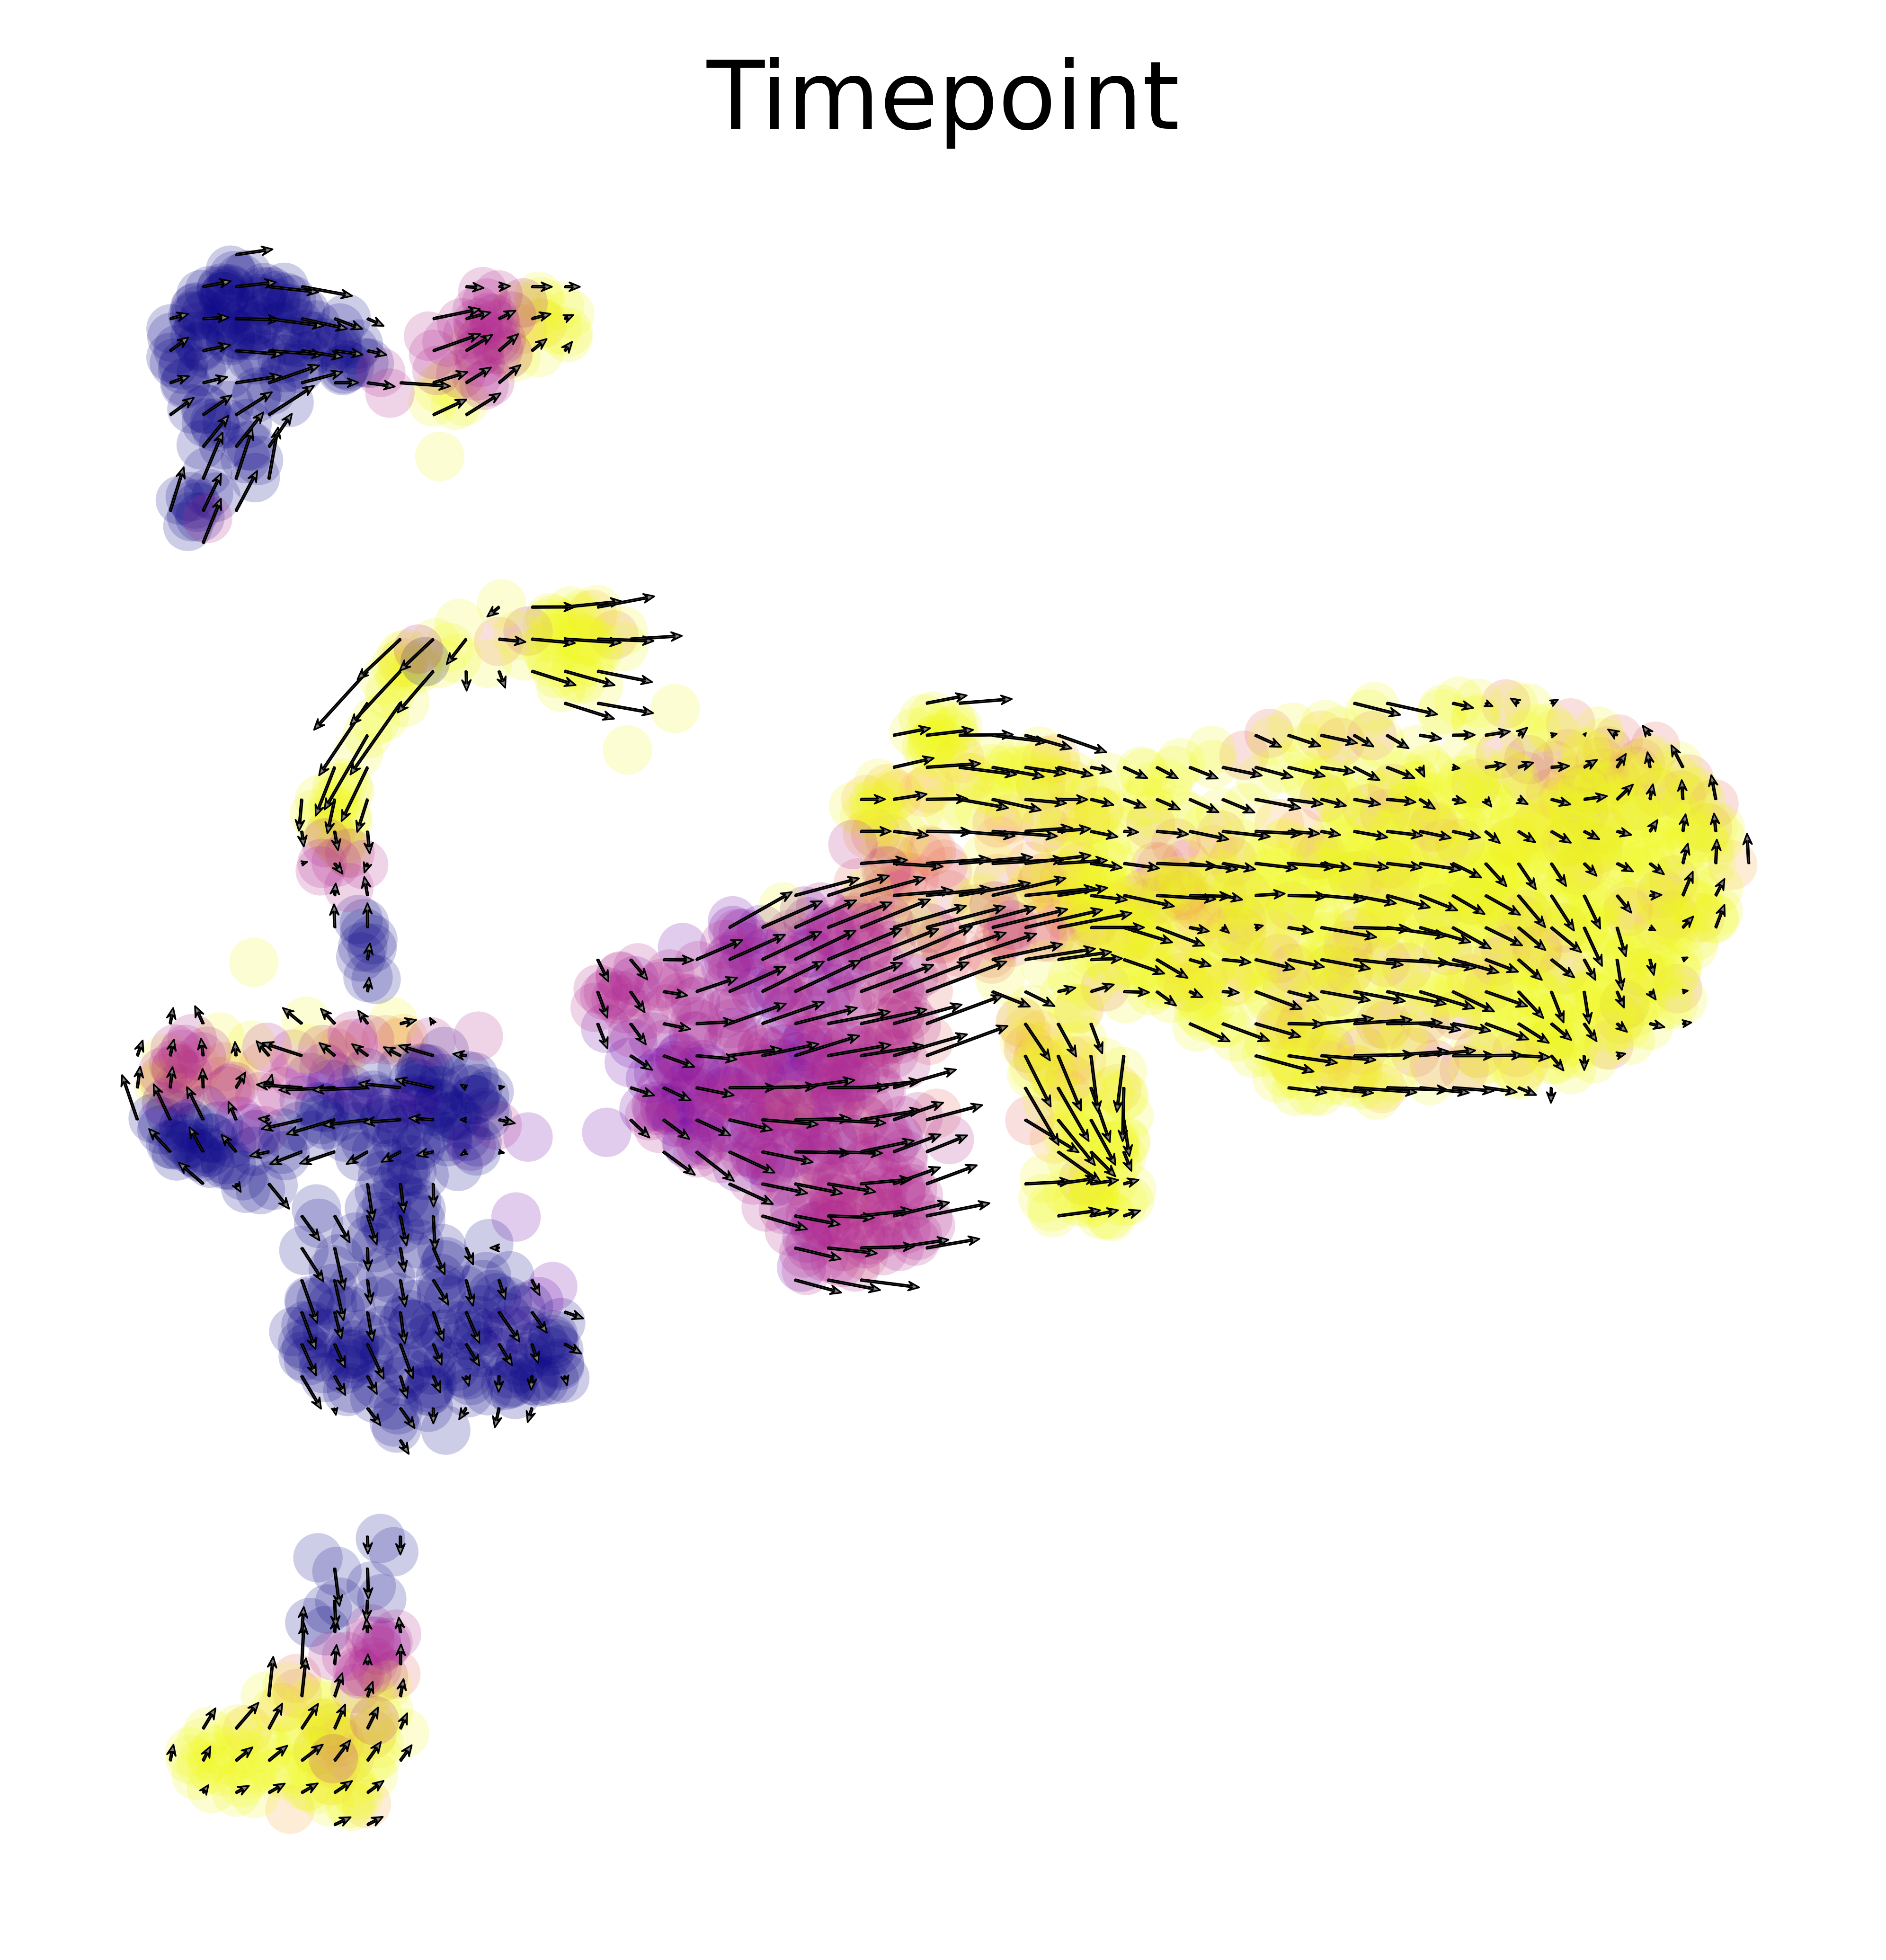

In [27]:
scv.pl.velocity_embedding_grid(adata, color = "Timepoint", figsize=(4,4),
                               arrow_length = 5, alpha=0.2, min_mass = 10,
                               dpi=600, 
                               save="VelocityPlot_GridArrows_Timepoint.pdf")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_VelocityPlot_Timepoint_smootharrows_thinlines.png


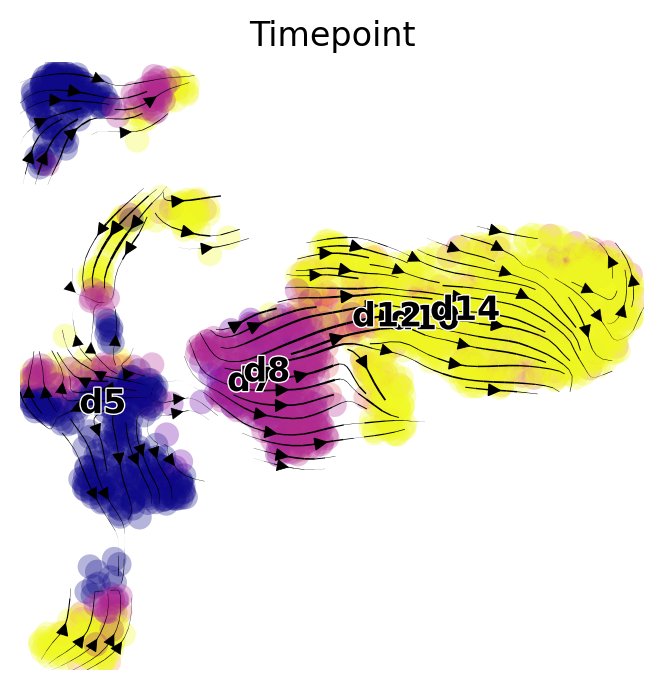

In [28]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="Timepoint", linewidth = 0.5,
                                 figsize=(4,4),save="VelocityPlot_Timepoint_smootharrows_thinlines.pdf")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_VelocityPlot_OriginalClusters_smootharrows_thinlines.png


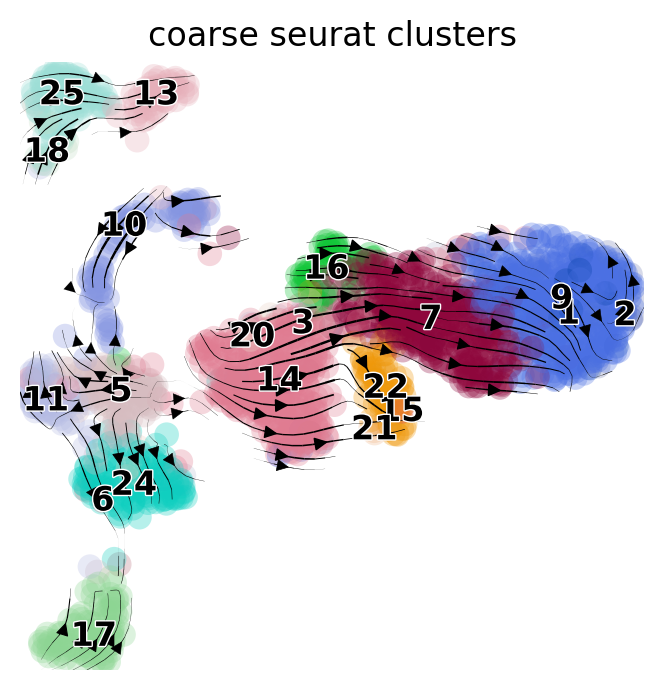

In [29]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="coarse_seurat_clusters", linewidth = 0.5,
                                 figsize=(4,4),save="VelocityPlot_OriginalClusters_smootharrows_thinlines.pdf")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_VelocityPlot_COL3A1_smootharrows_thinlines.png


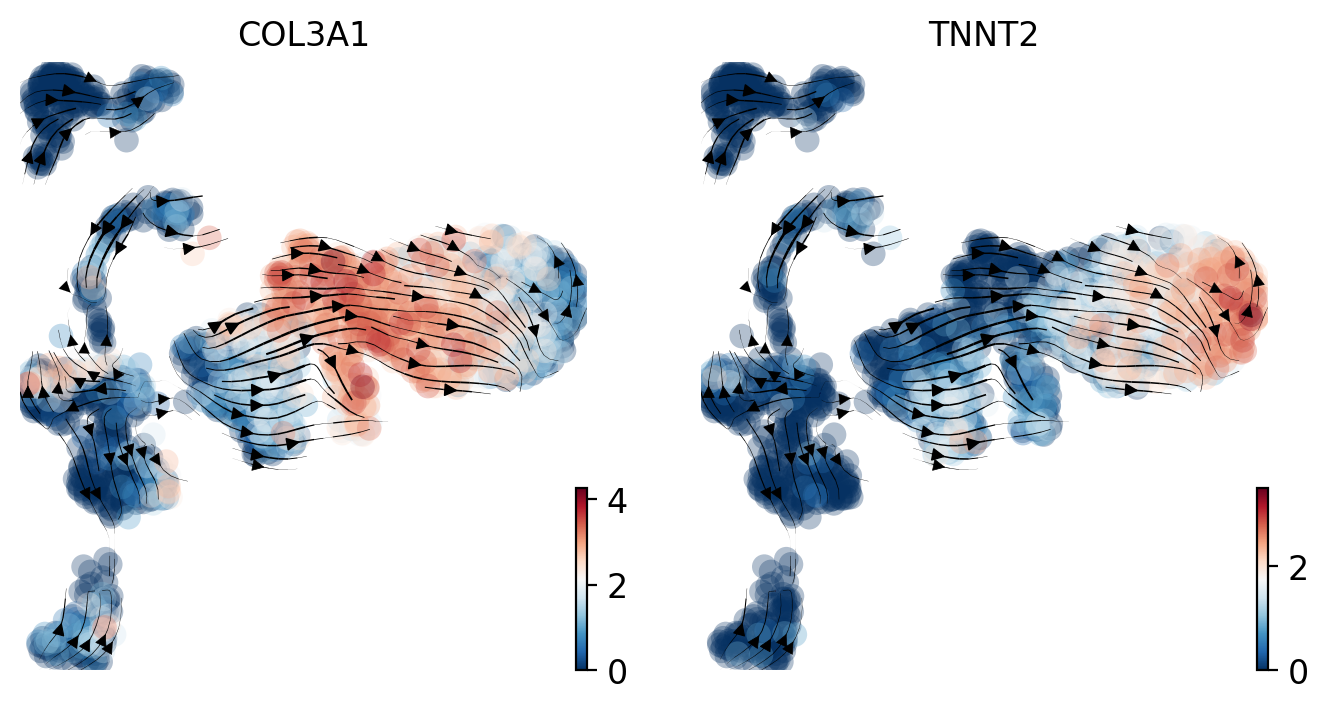

In [33]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=["COL3A1","TNNT2"], linewidth = 0.5,
                                 figsize=(4,4),save="VelocityPlot_COL3A1_smootharrows_thinlines.pdf")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_VelocityPlot_ISL1_smootharrows_thinlines.png


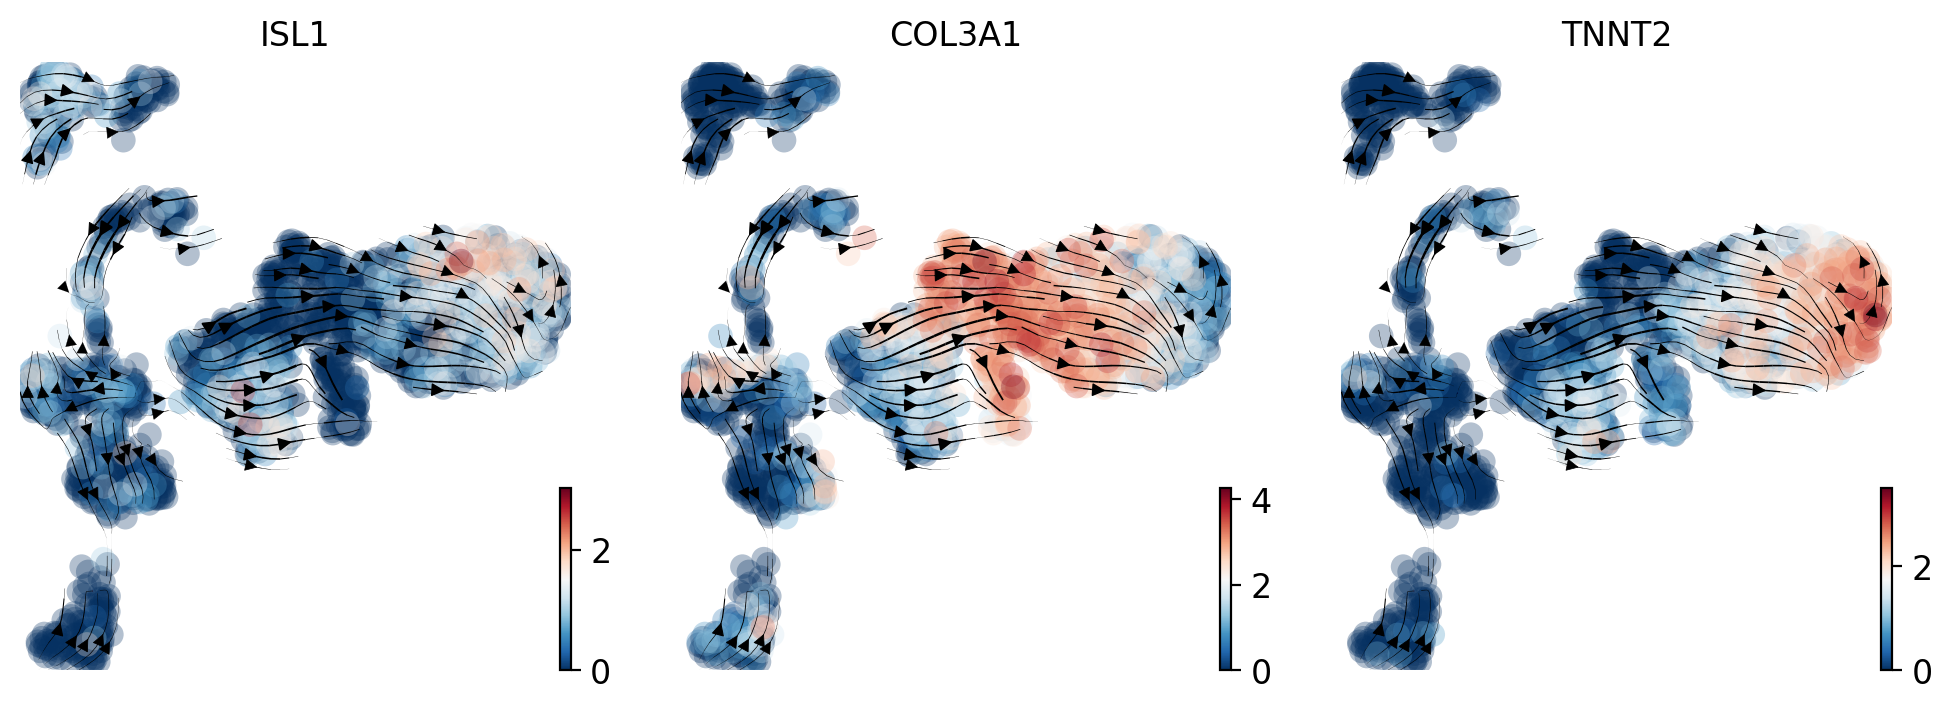

In [37]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=["ISL1","COL3A1","TNNT2"], linewidth = 0.5,
                                 figsize=(4,4),save="VelocityPlot_ISL1_smootharrows_thinlines.pdf")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_VelocityPlot_OriginalClusters_smootharrows_thinlines.png


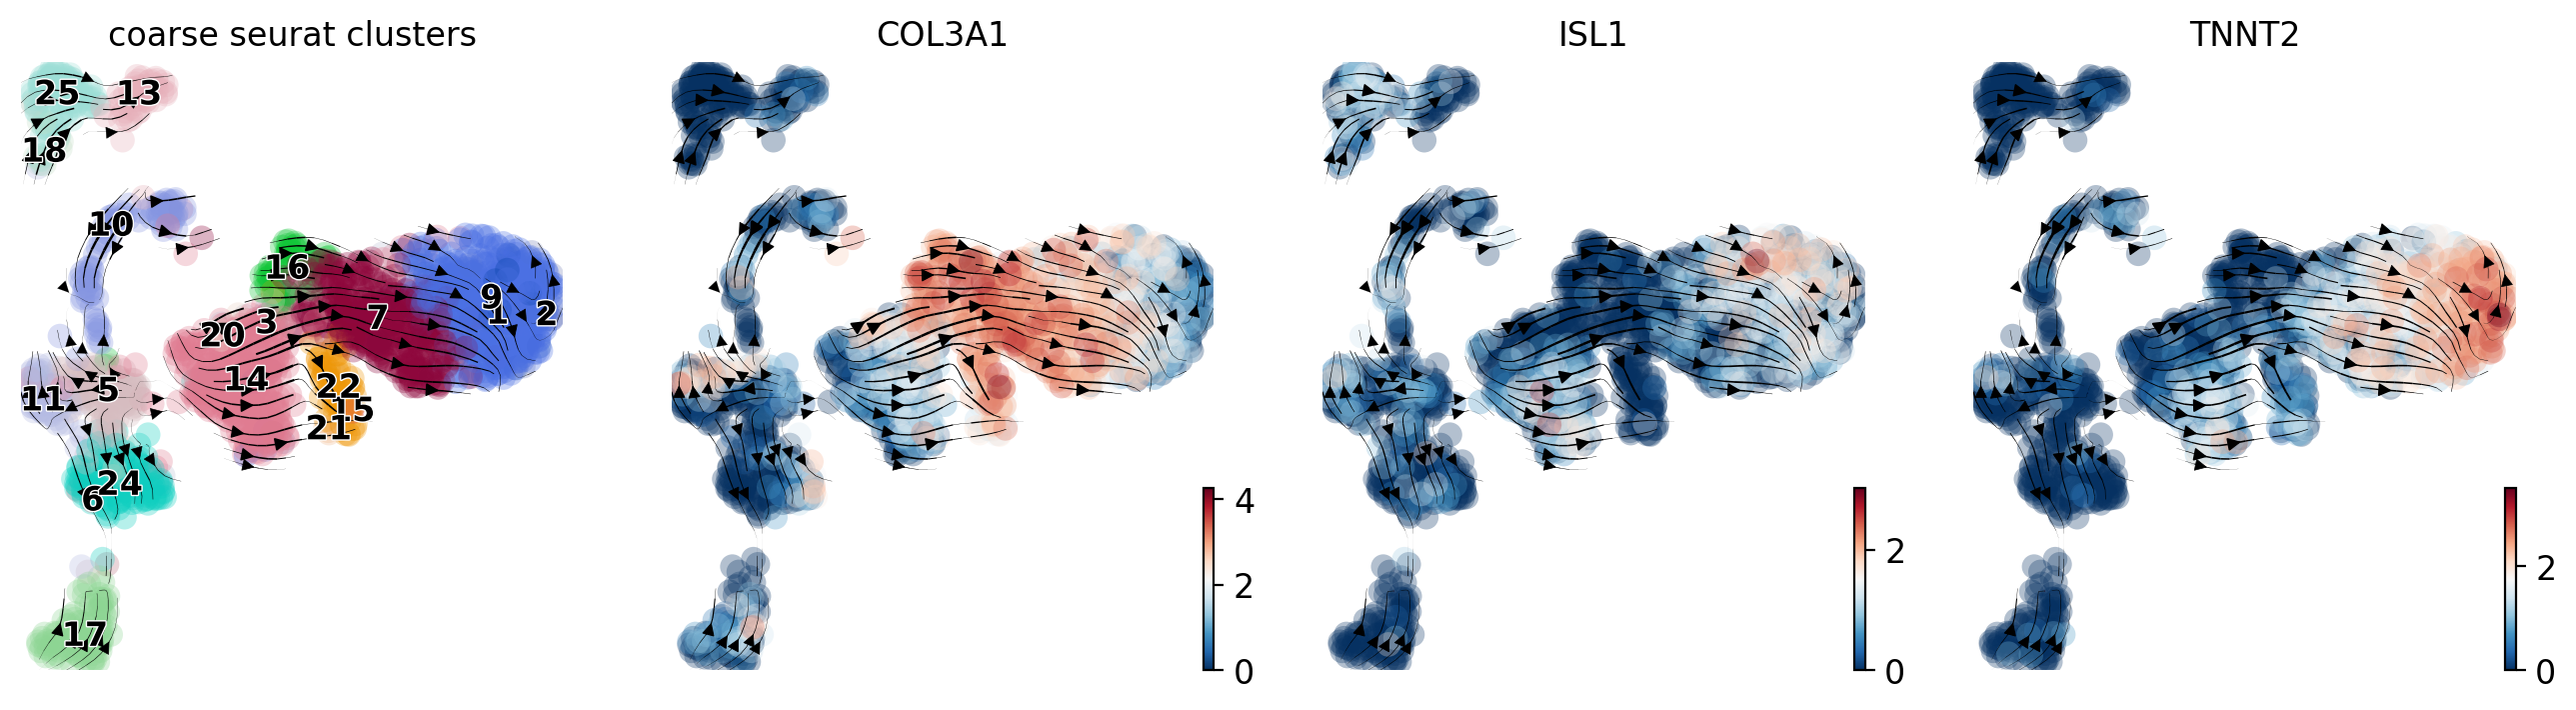

In [36]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=["coarse_seurat_clusters","COL3A1","ISL1","TNNT2"], linewidth = 0.5,
                                 figsize=(4,4),save="VelocityPlot_OriginalClusters_smootharrows_thinlines.pdf")

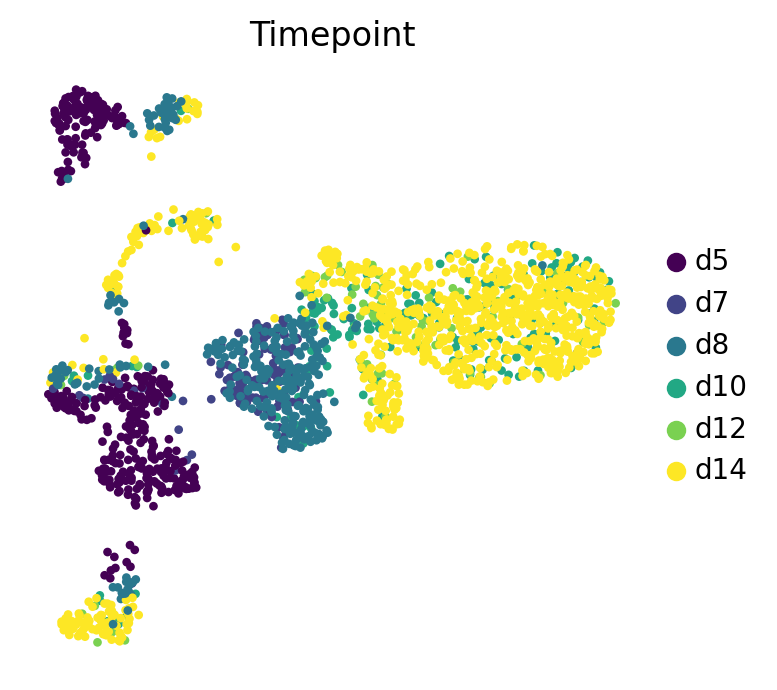

In [35]:
scv.pl.umap(adata, 
            color = "Timepoint", 
            palette = "viridis", 
            legend_loc='right margin', 
            legend_fontsize=10, 
            legend_fontoutline=2, 
            figsize = (4,4))

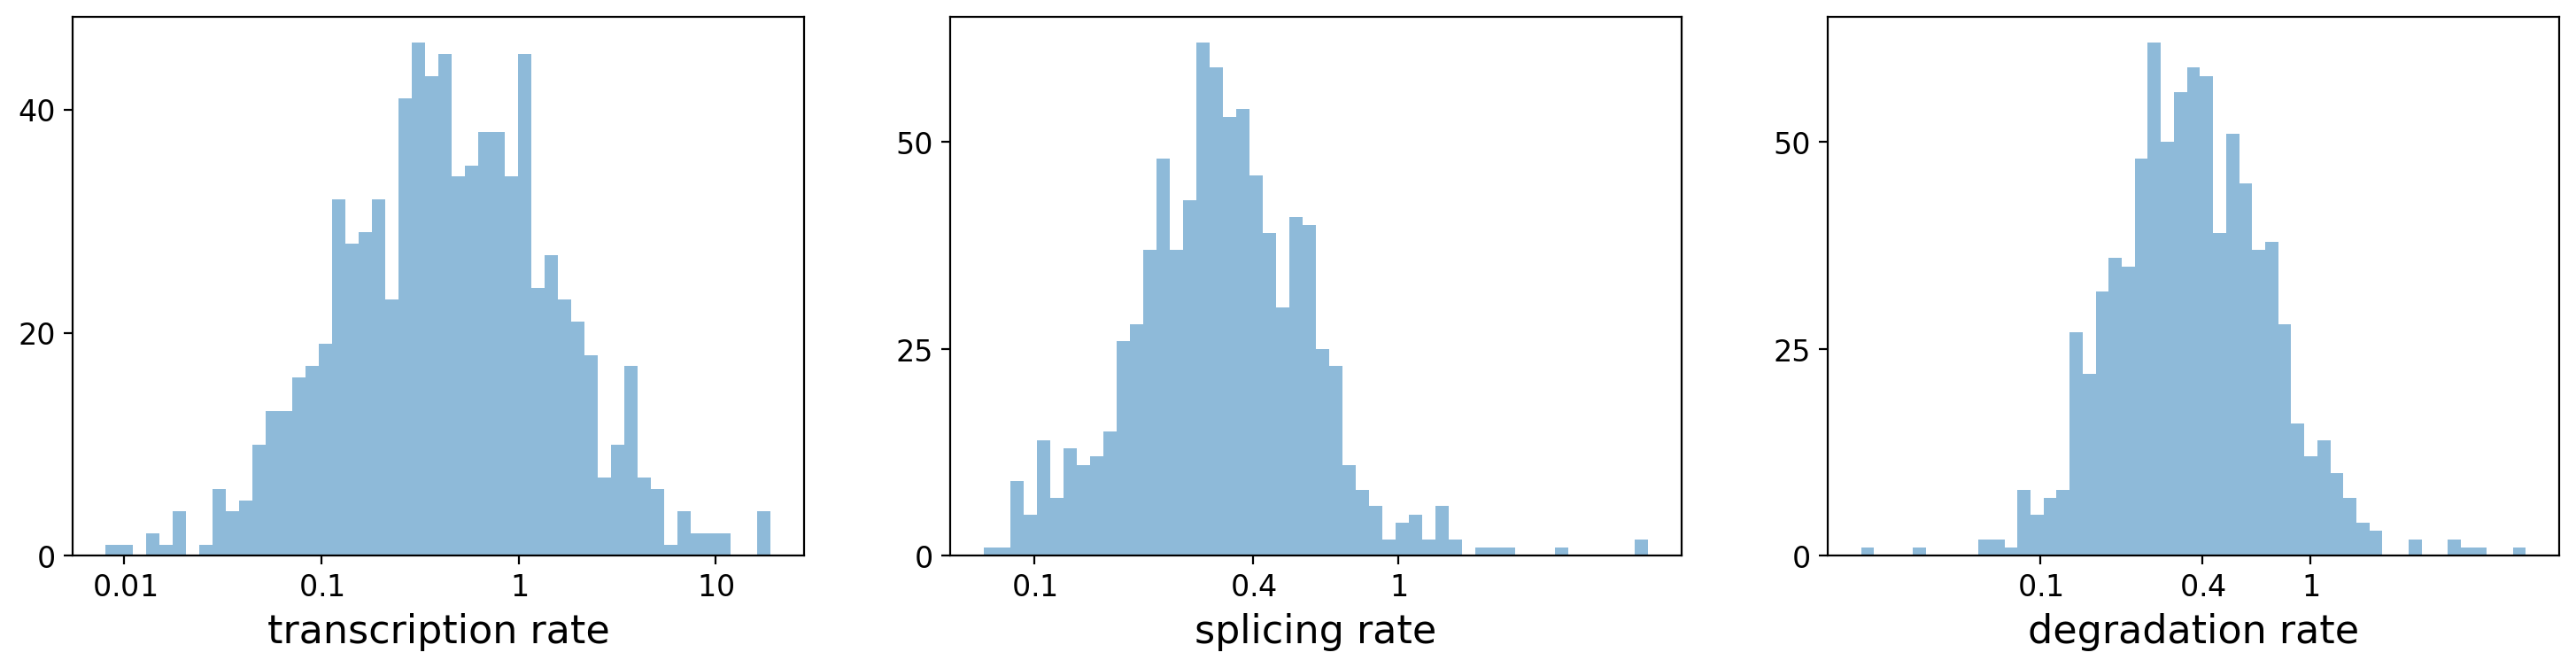

/vol/mbconda/snabel/anaconda3/envs/py_scvelo/lib/python3.8/site-packages/scvelo/read_load.py:406: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.var_names = df.index


fit_r2  fit_alpha   fit_beta  fit_gamma    fit_t_  fit_scaling  \
C1orf63  0.500028   1.045749   2.717623   0.400589  8.183231     0.087501   
LIN28A   0.315970   3.981551   9.724531   0.412157  3.444739     0.032694   
FGR      0.045360   0.034565   0.984611   0.314308  8.243537     0.658636   
IFI6     0.111288   1.480982  25.314781   1.182638  2.579894     0.024335   
SESN2    0.563837   0.506950   1.428813   0.645767  7.315083     0.224444   

         fit_std_u  fit_std_s  fit_likelihood  fit_u0  fit_s0  \
C1orf63   0.068147   0.449762        0.150230     0.0     0.0   
LIN28A    0.085397   1.394514        0.114140     0.0     0.0   
FGR       0.010851   0.026813        0.000302     0.0     0.0   
IFI6      0.012663   0.245872        0.132026     0.0     0.0   
SESN2     0.053419   0.109781        0.096275     0.0     0.0   

         fit_pval_steady  fit_steady_u  fit_steady_s  fit_variance  \
C1orf63         0.493903      0.248765      2.722018      1.790275   
LIN28A          0.498319      0.385098      3.020266      2.813217   
FGR             0.000170      0.020689      0.068873      0.448716   
IFI6            0.473996      0.042957      0.680619      1.158064   
SESN2           0.482248      0.270557      0.694295      2.040985   

         fit_alignment_scaling  
C1orf63               2.312915  
LIN28A                1.543809  
FGR                   2.677371  
IFI6                  0.730480  
SESN2                 1.368151

In [32]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()
